In [1]:
import os
#os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'

import jax
import itertools
import matplotlib.cm as cm
import numpy as np
import matplotlib
# Prevent ptitprince from raising cmap errors
cm.register_cmap = lambda name, cmap : matplotlib.colormaps.register(cmap, name=name)
import ptitprince as pt

import jax.numpy as jnp
import pypomp as pp
import ipywidgets as widgets
import pandas as pd
import copy

from jax import jit, grad
from functools import partial

from tqdm import tqdm


import matplotlib.pyplot as plt
plt.style.use('matplotlibrc')
np.set_printoptions(suppress=True)

In [ ]:
from pypomp.train import _jgrad_mop
d = pp.dacca(gamma=False)
theta = d.theta
theta_orig = np.hstack(list(d.par_trans.to_est(theta[0]).values()))
grads = {'0.0' : [], '1.0' : [], '0.97' : []}
alphas = [0.,1.,0.97]
for i in tqdm(range(100)):
  for alpha in alphas:
    d.train(J=10000, M=1, 
                          theta=theta,
                        optimizer='SGD', eta=1, 
                          ls=False, scale=False, 
                          alpha=alpha, key=jax.random.PRNGKey(i))
    theta_new = np.hstack(list(d.par_trans.to_est(d.theta[0]).values()))
    grads[str(alpha)].append(theta_new - theta_orig)

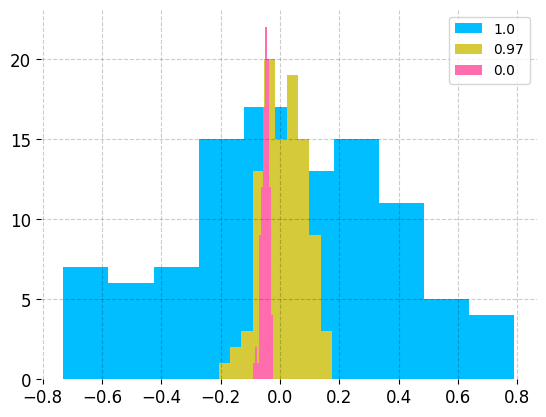

In [88]:
for alpha in [1.0, 0.97, 0.0]:
    plt.hist(np.array(grads[str(alpha)])[:,0], alpha=1, label=alpha)
plt.legend()

In [2]:
params_box = {'gamma': [10.,  40.],
                 'epsilon': [0.20, 30.00],
                 'rho': [0.0, 0.0],
                 'm': [0.03, 0.60],
                 'c': [1.0, 1.0],
                 'beta_trend': [-1.*0.01, -0.*0.01],
                 'bs1': [-4., 4.],
                 'bs2': [0., 8.],
                 'bs3': [-4., 4.],
                 'bs4': [0., 8.],
                 'bs5': [0., 8.],
                 'bs6': [0., 8.],
                 'sigma': [1., 5.],
                 'tau': [0.1, 0.5],
                 'omega': [np.exp(-4.5), np.exp(-4.5)],
                 'omegas1': [-10., -0.],
                 'omegas2': [-10., -0.],
                 'omegas3': [-10., -0.],
                 'omegas4': [-10., -0.],
                 'omegas5': [-10., -0.],
                 'omegas6': [-10., -0.]}

In [ ]:
MAIN_SEED = 631409
key = jax.random.key(MAIN_SEED)
np.random.seed(MAIN_SEED)

RW_SD = pp.RWSigma(
    sigmas={
        "gamma": 0.02,
        "m": 0.02,
        "rho": 0.0,
        "epsilon": 0.02,
        "omega": 0.02,
        "c": 0.02,
        "beta_trend": 0.02,
        "sigma": 0.02,
        "tau": 0.02,
        "bs1": 0.02,
        "bs2": 0.02,
        "bs3": 0.02,
        "bs4": 0.02,
        "bs5": 0.02,
        "bs6": 0.02,
        "omegas1": 0.02,
        "omegas2": 0.02,
        "omegas3": 0.02,
        "omegas4": 0.02,
        "omegas5": 0.02,
        "omegas6": 0.02,
    },
    init_names=[],
)

COOLING_RATE = 0.95
NP_FITR = NP_EVAL = 10000

N_TRIALS = 100
NREPS_EVAL = 1
NFITR_MIF = 40
NFITR_GD = 60


# NREPS_EVAL = 1
# NFITR_MIF = 2 #40
# NFITR_GD = 2
#N_TRIALS = 2
alphas = [0.,1.,0.97]
daccas_pre = []
daccas_mif = []
daccas_alphas = {str(alpha) : [] for alpha in alphas}

starting_logliks = []
mif_logliks = []


dacca_obj = pp.dacca(gamma=False)
for trial in tqdm(range(N_TRIALS)):
    dacca_obj.results_history = []
    key, subkey = jax.random.split(key)
    theta = pp.Pomp.sample_params(params_box, 1, key=subkey)[0]
    key, subkey = jax.random.split(key)
    dacca_obj.pfilter(J=NP_EVAL, reps=NREPS_EVAL, key=subkey, theta=theta)
    print('trial ' + str(trial) + ' init :', dacca_obj.results())
    
    key, subkey = jax.random.split(key)
    dacca_obj.mif(
            theta=theta,
            rw_sd=RW_SD,
            M=NFITR_MIF,
            a=COOLING_RATE,
            J=NP_FITR,
            key=subkey
        )
    
    #warm_start_theta = dacca_obj.theta
    trace = dacca_obj.results_history[-1]['traces']
    argmax = int(trace[0,:,0].argmax())

    warm_start_theta = pd.DataFrame(trace[0,argmax,1:].values, index=theta.keys())[0]
    warm_start_theta = [{k : float(v) for k, v in warm_start_theta.items()}]
    
    key, subkey = jax.random.split(key)
    dacca_obj.pfilter(J=NP_EVAL, reps=NREPS_EVAL)
    print('trial ' + str(trial) + ' mif 40:', dacca_obj.results())
    daccas_pre.append(dacca_obj.results())

    key, subkey = jax.random.split(key)
    dacca_obj.mif(
                theta=theta,
                rw_sd=RW_SD,
                M=NFITR_MIF+NFITR_GD,
                a=COOLING_RATE,
                J=NP_FITR,
                key=subkey
            )
    
    key, subkey = jax.random.split(key)
    dacca_obj.pfilter(J=NP_EVAL, reps=NREPS_EVAL)
    print('trial ' + str(trial) + ' mif 100:', dacca_obj.results())
    daccas_mif.append(dacca_obj.results())

    for alpha, eta in tqdm(zip(alphas, [0.1, 0.05, 0.2])):
        key, subkey = jax.random.split(key)
        dacca_obj.train(J=NP_FITR, M=NFITR_GD, 
                          theta=warm_start_theta,
                        optimizer='SGD', eta=eta, 
                          ls=False, scale=False, 
                          alpha=alpha, key=subkey)
        key, subkey = jax.random.split(key)
        dacca_obj.pfilter(J=NP_EVAL, reps=NREPS_EVAL)
        print('trial ' + str(trial) + ' alpha=', str(alpha),':', dacca_obj.results())
        daccas_alphas[str(alpha)].append(dacca_obj.results())

  0%|          | 0/100 [00:00<?, ?it/s]

trial 0 init :         logLik  se      gamma    epsilon  rho         m    c  beta_trend  \
0 -14715.84375 NaN  34.645187  10.470056  0.0  0.533827  1.0   -0.002874   

        bs1       bs2  ...      bs6     sigma       tau     omega   omegas1  \
0 -0.793052  5.290325  ...  2.56705  3.964456  0.112241  0.011109 -2.392839   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -7.877694 -1.420382 -3.457628 -0.317747 -3.187977  

[1 rows x 23 columns]
trial 0 mif 40:         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3902.653076 NaN  27.110182  0.055534  0.0  16.841959  0.000474  1.0   

   beta_trend     sigma  ...      bs3       bs4       bs5       bs6  omegas1  \
0    0.000295  3.316007  ... -0.70295  3.609764  3.644262  4.076638  -1.1719   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -4.326884 -3.224901 -3.353596 -9.565264 -9.123214  

[1 rows x 23 columns]
trial 0 mif 100:         logLik  se      gamma         m  rho   epsilon     omega    


0it [00:00, ?it/s]

In [ ]:
dacca_obj.results()

,logLik,se,gamma,m,rho,epsilon,omega,c,beta_trend,sigma,...,bs3,bs4,bs5,bs6,omegas1,omegas2,omegas3,omegas4,omegas5,omegas6
0,-24867.998047,NaN,1.299844,-3.120551,-inf,0.985573,-7.560599,inf,-23.142998,1.552134,...,-5.032645,-2.040696,1.194478,-1.7298,-0.868005,-5.157048,-2.049488,-6.195749,-2.077846,-0.539867


In [ ]:
[r['traces'] for r in dacca_obj.results_history if r['method']=='mif']